# PROJECT 2: Investigating the history of number words

### Dependencies:
1. It is assumed that the user has anaconda installed on their system
2. Additional from anaconda, following commands from the terminal would install additional modules to run this notebook. <br>
    pip install distance<br>
    pip install seaborn <br>
   




In [1]:
#Loading Dependencies
import pandas as pd
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn 
seaborn.set_context("talk")
seaborn.set_style("whitegrid")
from os import listdir
from os.path import isfile, join
import re
import math
import random
from distance import levenshtein as edit_d, hamming, nlevenshtein as nedit_d, jaccard

#Data_Paths:
data_path = 'csv_files/'
metadata_ie = 'Languages_indo_euro.csv'
metadata_aa = 'Languages_afro_asiatic.csv'

### Loading data

Let's store all the language datasets in a dictionary so that we can fetch them later on easily

In [2]:
#Store all languages datasets in a dictionary 
lang_data = {file[18:-4]: pd.read_csv(data_path + file, encoding='utf8') for file in listdir(data_path)}

#No. of languages:
print("Number of languages: %d" % len(lang_data))


Number of languages: 7221


Let's also store the metadata of some Classification glottologs:

In [3]:
#Indo_European metadata
indo_euro = pd.read_csv(metadata_ie, encoding='utf8')
print("Number of indo european languages: %d" % len(indo_euro))

#Afro_asiatic metadata
afro_asia = pd.read_csv(metadata_aa, encoding='utf8')
print("Number of afro asiatic languages: %d" % len(afro_asia))

Number of indo european languages: 414
Number of afro asiatic languages: 358


## Main Approach:

1. **Categorization of Languages by Glottolog Classification**: <br>
We begin by creating two independent datasets, one for Indo-European languages and the other for Afro-Asiatic languages. <br>

2. **Categorization of Languages by Year of Extinction**: <br>
We create three clusters of languages: <br>
2.1 Ancient <br>
2.2 Recently Extinct <br>
2.3 Non-Extinct <br>

3. We analyze the similarities of **'number words'** VS **'other words'** for each of these clusters and compare the results on between different glottolog classifications**. <br>

4. We use **different similarity metrics** to analyze the results to avoid any bias of a particular metric. We use the following metrics:
 * Edit Distance
 * Normalized Edit Distance
 * Normalized Hamming Distance
 * Jaccard Distance
 * Phonetic Distance


Defining some functions below so that they can be used later efficiently.
Each function's description is described within the function

In [4]:
def ancient_langs(data):
    '''
    Input: asjp languages metadata 
    Output: a list of ancient language names
    '''
    #store names of languages that are extinct
    names = data[data.long_extinct == True].name.values
    
    #replace spaces by '_' and changes everything to uppercase
    names = [re.sub(r' ', r'_', name).upper() for name in names] 
    
    print("%d ancient languages stored" % len(names))
    print(names)
    print("\n")
    
    return [(x, 'ancient') for x in names]
    
def recently_extinct(data):
    '''
    Input: asjp language metadata 
    Output: a list of names of recently extinct languages
    '''
    #store names of languages that are extinct
    names = data[data.recently_extinct == True].name.values
    
    #replace spaces by '_' and changes everything to uppercase
    names = [re.sub(r' ', r'_', name).upper() for name in names] 
    
    print("%d recently extinct languages stored" % len(names))
    print(names)
    print("\n")
    
    return [(x, 'recently_extinct') for x in names]

def new_languages(data):
    '''
    Input: asjp language metadata 
    Output: a short subset of list of names of recent languages (non-extinct)
    '''
    random.seed(12)
    
    #store names of languages that are extinct
    names = data[(data.recently_extinct == False) & \
                (data.long_extinct == False)].name.values
    
    #Select random 10 language names (as the whole list is too long)
    random.shuffle(names)
    names = names[:13]
    
    #replace spaces by '_' and changes everything to uppercase
    names = [re.sub(r' ', r'_', name).upper() for name in names] 
    
    random.shuffle(names)
    
    print("%d new languages stored" % len(names))
    print(names)
    print("\n")
    
    return [(x, 'non_extinct') for x in names]

def vocab(language):
    '''
    Input: language name (a string) 
    Output: list of words in that language
    '''
    vocab = set(list(lang_data[language].Parameter_name.values))
    
    print("%d words of %s stored" % (len(vocab), language))
    
    return list(vocab)



### Similarity Metrics:

#### Phonetic distance metric

In [5]:
#Vowels
vM = np.matrix([['i','3','u'],
				['e','3','o'],
				['E','a','o']])

#Consonants
consonants = ['p','b','t','d','T','k','g','q','G','7','m','4','n','5','N',
			  'r','c','C','j','f','v','8','s','z','S','Z','x','X','h','w',
			  'y','l','L','!']
sonorants = ['m','4','n','5','N','r','w','l','L']
cM = np.matrix([
	  ['p','b','-','-','-','-','t','d','-','-','-','-','T','T','k','g','q','G','7','-'],
	  ['-','m','-','-','-','4','-','n','-','-','-','-','-','5','-','N','-','-','-','-'],
	  ['-','r','-','-','-','-','-','r','-','r','-','-','-','-','-','r','-','-','-','-'],
	  ['-','-','-','-','-','-','c','c','-','-','C','j','-','-','-','-','-','-','-','-'],
	  ['p','b','f','v','8','8','s','z','S','Z','-','-','-','-','x','x','X','X','h','h'],
	  ['-','w','-','-','-','-','-','-','-','-','-','-','-','y','-','-','-','-','-','-'],
	  ['-','-','-','-','-','-','-','l','-','-','-','-','-','L','-','L','-','-','-','-'],
	  ['!','-','-','-','!','-','!','-','-','-','!','-','-','-','-','-','-','-','-','-']])

#All
chars = consonants+['i','3','u','e','o','E','a']

#Weights
emptyC = 20 #original: 20
skipC = 1 #original: 1
switchC = 35 #if p is a consonant and q is a vowel or vice versa; original: 35
sswitchC = 20 #between vowel and sonorant; orignal: 20
vowelC = 10 #original: 10

def phDistance(word1, word2):
	#create two work vectors of integer distances
	maxlength = max(len(word1), len(word2))
	v1, v2 = [0]*maxlength, [0]*maxlength
	c = 0
	for i, j in enumerate(word1):
		v1[i] = j
	for i, j in enumerate(word2):
		v2[i] = j
	for i, j in enumerate(v1):
		p = j
		q = v2[i]
		c += findCost(p,q)
	return c

def findCost(p,q):
	cost = 0
	if (p == 0 or q == 0):
		cost = emptyC
	elif (p == '-' or q == '-'): #result of aline
		cost = 15
	elif (p not in chars or q not in chars):
		cost = skipC
	elif ((p in sonorants and q not in consonants) or
		  (q in sonorants and p not in consonants)):
		cost = sswitchC
	elif ((p in consonants and q not in consonants) or
		  (q in consonants and p not in consonants)):
		cost = switchC
	elif (p == q):
		cost = 0
	else:
		cost = findDistance(p,q)
	return cost
	
def findDistance(p, q):
    source = vM
    vowels = True
    if (p and q in consonants):
        source = cM
        vowels = False
    pa = np.asarray(np.where(source==p)).T
    qa = np.asarray(np.where(source==q)).T
    dlist = []
    for i in pa:
        for j in qa:
            eucledian = (j[1]-j[0])**2 + (i[1]-i[0])**2
            dlist.append(np.sqrt(eucledian))
    d = min(dlist)
    if (vowels):
        d = d*vowelC
    return d

#### Lexical distance metrics

In [6]:
#From inbuilt packages:
def similarity_metric(metric, lang1, lang2, word):
    '''
    Input:  1. metric: Similarity function's name  : {'edit_dist', 'jaccard'}
            2. lang1: first language's name
            3. lang2: second language's name
            4. word: word to be compared
            
    Output: Value of similarity metric calculated on the word b/w lang1 and lang2
    '''
    values_lang1 = lang_data[lang1][lang_data[lang1].Parameter_name == word].Value.values
    values_lang2 = lang_data[lang2][lang_data[lang2].Parameter_name == word].Value.values
    #If multiple values, pick the one with smallest length
    index1 = list(values_lang1).index(min(values_lang1, key=len))
    index2 = list(values_lang2).index(min(values_lang2, key=len))
    
    if metric == 'edit_d':
        return edit_d(values_lang1[index1], values_lang2[index2])
    
    elif metric == 'nedit_d':  #Normalized edit distance
        return nedit_d(values_lang1[index1], values_lang2[index2], method=2) #longest alignment
        
    elif metric == 'norm_hamming':
        return hamming(values_lang1[index1], values_lang2[index2], normalized = True)
    
    elif metric == 'jaccard':
        return jaccard(values_lang1[index1], values_lang2[index2])
    
    elif metric == 'ph_dist':
        return phDistance(values_lang1[index1], values_lang2[index2])
    else:
        return None

## Section 1. Indo-European Languages

We start by analyzing the similarites of words on Indo-European languages.

The names of these languages are stored in lists to be fetched later on <br>


In [7]:
#Store the names of languages in a list 
ancient_l = ancient_langs(indo_euro)
rec_ext_l = recently_extinct(indo_euro)
new_lang_l = new_languages(indo_euro)

#Common words
#words = vocab('ENGLISH')
words = ['one', 'two', 'I', 'you', 'we', 'person', 'fish', 'dog', \
         'louse', 'tree', 'leaf', 'skin', 'blood', 'bone', 'horn', \
        'ear', 'eye', 'nose', 'tooth', 'tongue', 'knee', 'hand', \
        'breast', 'liver', 'drink', 'see', 'hear', 'die', 'come',
        'sun', 'star', 'water', 'stone', 'fire', 'path',\
        'mountain', 'night', 'full', 'new', 'name']

21 ancient languages stored
['HITTITE', 'PALAIC', 'ARMENIAN_CLASSICAL', 'OLD_PRUSSIAN', 'CORNISH', 'GOTHIC', 'OLD_ENGLISH', 'OLD_FRISIAN', 'OLD_HIGH_GERMAN', 'OLD_LOW_FRANCONIAN', 'OLD_NORSE', 'OLD_SAXON', 'GREEK_ANCIENT', 'ILLYRIAN', 'PALI', 'SANSKRIT', 'AVESTAN', 'AVESTAN_2', 'OLD_PERSIAN', 'LATIN', 'OLD_CHURCH_SLAVONIC']


13 recently extinct languages stored
['MANX', 'OLD_IRISH', 'WELSH_ROMANI', 'DALMATIAN', 'EMILIANO_CARPIGIANO', 'EMILIANO_FERRARESE', 'EMILIANO_REGGIANO', 'ROMAGNOL_RAVENNATE', 'COMMON_TOCHARIAN', 'TOCHARIAN_A', 'TOCHARIAN_B', 'BERBICE_DUTCH_CREOLE', 'NEGERHOLLANDS']


13 new languages stored
['KASHMIRI', 'KOSOVO_ARLI_ROMANI', 'PARGAM_NISAR_KHOWAR', 'DOMAAKI', 'SANDNES_NORWEGIAN', 'KASHUBIAN', 'GULLAH', 'ASHRET_PHALURA', 'FRENCH', 'JUDEO_TAT_2', 'ENGLISH', 'PALAS_SHINA', 'CHAMAN_PASHTO']




### 1.1 Metric: EDIT DISTANCE
#### Dataframe to compare EDIT DISTANCES between phonemes of words in different languages

In [8]:
all_langs = new_lang_l + rec_ext_l + ancient_l

#Multi index for pandas dataframe
index_adv = pd.MultiIndex.from_tuples(all_langs, names=['language', 'cluster'])

Calculating edit_distance between each pair of words between different languages

In [9]:
#Create an empty dataframe with columns as words and multi index (language, cluster)
df = pd.DataFrame(columns = words, index = index_adv, dtype=float)

#Evaluate metrics for each pair of language
for (lang, cluster) in all_langs:
    for word in words:
        try:
            df.loc[(lang, cluster),word] = similarity_metric('edit_d', 'ENGLISH', lang, word)
        except:
            pass   #for words not found in a particular language               

#### A look at EDIT_DISTANCE data frame

The NaN values mean that the particular word was not found in that language

In [10]:
df

,,one,two,I,you,we,person,fish,dog,louse,tree,...,star,water,stone,fire,path,mountain,night,full,new,name
language,cluster,,,,,,,,,,,,,,,,,,,,,
KASHMIRI,non_extinct,3.0,3.0,3.0,2.0,3.0,5.0,3.0,3.0,2.0,3.0,...,3.0,4.0,4.0,3.0,3.0,7.0,3.0,5.0,1.0,2.0
KOSOVO_ARLI_ROMANI,non_extinct,3.0,2.0,2.0,1.0,4.0,6.0,6.0,5.0,3.0,5.0,...,6.0,4.0,4.0,4.0,5.0,6.0,3.0,7.0,3.0,3.0
PARGAM_NISAR_KHOWAR,non_extinct,3.0,1.0,3.0,1.0,3.0,6.0,4.0,4.0,NaN,3.0,...,2.0,5.0,4.0,4.0,2.0,NaN,3.0,NaN,2.0,1.0
DOMAAKI,non_extinct,3.0,2.0,NaN,1.0,3.0,NaN,6.0,6.0,NaN,2.0,...,3.0,5.0,3.0,4.0,NaN,NaN,5.0,NaN,3.0,1.0
SANDNES_NORWEGIAN,non_extinct,2.0,1.0,1.0,NaN,2.0,5.0,2.0,3.0,1.0,1.0,...,4.0,3.0,4.0,4.0,3.0,7.0,2.0,NaN,2.0,3.0
KASHUBIAN,non_extinct,4.0,3.0,2.0,2.0,2.0,NaN,4.0,5.0,NaN,7.0,...,NaN,4.0,4.0,4.0,5.0,6.0,3.0,5.0,3.0,6.0
GULLAH,non_extinct,1.0,0.0,2.0,0.0,0.0,3.0,NaN,1.0,NaN,0.0,...,NaN,3.0,NaN,2.0,2.0,7.0,1.0,0.0,NaN,0.0
ASHRET_PHALURA,non_extinct,3.0,1.0,2.0,1.0,2.0,6.0,5.0,6.0,NaN,3.0,...,3.0,5.0,4.0,4.0,3.0,NaN,3.0,NaN,2.0,2.0
FRENCH,non_extinct,3.0,2.0,2.0,2.0,2.0,6.0,7.0,3.0,3.0,4.0,...,5.0,5.0,5.0,3.0,3.0,5.0,2.0,4.0,2.0,2.0


#### Mean of Edit Distances for three clusters

In [11]:
#Missing Value imputations by Median
#df.fillna(df.median(), inplace=True)

#Mean Grouping by clsuters
df.groupby(level=['cluster']).mean()

,one,two,I,you,we,person,fish,dog,louse,tree,...,star,water,stone,fire,path,mountain,night,full,new,name
cluster,,,,,,,,,,,,,,,,,,,,,
ancient,3.055556,3.000000,2.411765,1.833333,2.411765,5.894737,4.117647,3.722222,3.875000,3.578947,...,2.882353,3.047619,3.210526,2.944444,3.500000,6.350,3.210526,3.055556,2.950000,2.684211
non_extinct,2.615385,1.692308,1.916667,1.250000,2.307692,4.700000,3.916667,3.461538,2.166667,2.846154,...,3.272727,3.923077,3.833333,3.307692,2.750000,5.625,2.769231,3.428571,2.250000,1.769231
recently_extinct,2.461538,1.923077,2.083333,1.384615,2.846154,5.666667,3.083333,3.076923,4.272727,4.000000,...,3.916667,3.538462,4.083333,3.153846,5.076923,5.500,3.333333,3.250000,1.846154,1.461538


#### 'Number' words Vs 'Other' words

In [12]:
number_words = list(df.columns[:2])
other_words = list(df.columns[2:])

df['number_words'] = df[number_words].mean(axis=1)
df['other_words'] = df[other_words].mean(axis=1)

df[['number_words', 'other_words']].groupby(level=['cluster']).mean()

,number_words,other_words
cluster,,
ancient,3.025000,3.697864
non_extinct,2.153846,3.216454
recently_extinct,2.192308,3.651545


### Visualizations
Box and whisker plot: colored box is the middle 50th percentile, whiskers are the 25th to 75th percentile, any outliers are represented by dots.

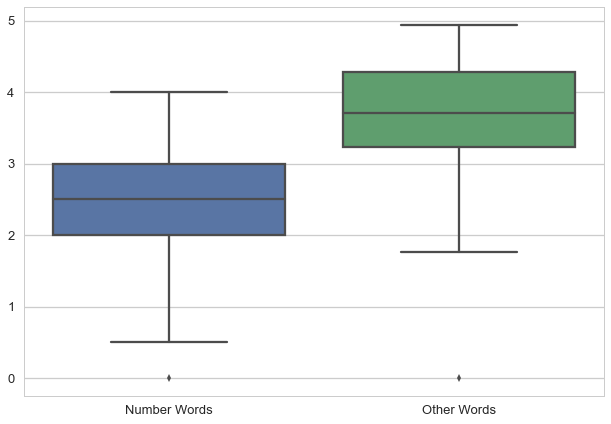

In [13]:
seaborn.boxplot(['Number Words', 'Other Words'], [df['number_words'].dropna(), df['other_words'].dropna()], orient='v')
plt.show()

Line plot: Edit distances by language for number words and other words.

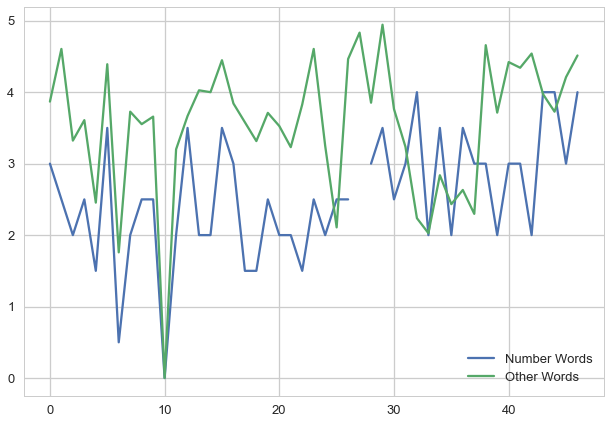

In [14]:
x = range(len(all_langs))
plt.plot(x, df['number_words'], label="Number Words")
plt.plot(x, df['other_words'], label="Other Words")
plt.legend(loc="best")
plt.show()

#### Statistical Analysis
We can do a t-test on the mean edit distances of the number words and the other words to see if they are statistically significantly different.<br>
**Null Hypothesis**: The means of 'number' words = the mean of 'other' words 

In [15]:
p_value = sp.stats.ttest_ind(df.values[-1], df.values[-2], nan_policy='omit')[1]

if p_value < 0.05:
    print('The p-value is %4.4f. This allows us to reject the null hypothesis.' % p_value)
else:
    print('The p-value is %4.4f. This does not allow us to reject the null hypothesis.' % p_value)

The p-value is 0.3319. This does not allow us to reject the null hypothesis.


### 1.2 METRIC: Normalized Edit DISTANCE

#### Dataframe based on normalized Edit Distance:
We can analyze all the results with respect to normalized edit distance as well

In [16]:
#Create an empty dataframe with columns as words and multi index (language, cluster)
df = pd.DataFrame(columns = words, index = index_adv, dtype=float)

for (lang, cluster) in all_langs:
    for word in words:
        try:
            df.loc[(lang, cluster),word] = similarity_metric('nedit_d', 'OLD_ENGLISH', lang, word)
        except:
            pass   #for words not found in a particular language 
              
#Missing Value imputations
df.fillna(df.median(), inplace=True)
df.groupby(level=['cluster']).mean()

,one,two,I,you,we,person,fish,dog,louse,tree,...,star,water,stone,fire,path,mountain,night,full,new,name
cluster,,,,,,,,,,,,,,,,,,,,,
ancient,0.684921,0.837160,0.674603,0.520635,0.814286,0.561527,0.558957,0.624603,0.653175,0.783277,...,0.497166,0.752381,0.608730,0.616667,0.882086,0.655896,0.618141,0.614626,0.626984,0.374603
non_extinct,0.817949,0.934066,0.974359,0.692308,0.839744,0.731502,0.839011,0.811538,0.644872,0.765385,...,0.573718,0.861538,0.767033,0.752564,0.935897,0.874908,0.653846,0.753846,0.625641,0.543407
recently_extinct,0.673077,0.880495,0.923077,0.685897,0.826923,0.756227,0.700000,0.734615,0.830128,0.861538,...,0.660714,0.848718,0.721612,0.689744,0.928480,0.880769,0.661538,0.858974,0.682051,0.520513


In [17]:
number_words = list(df.columns[:2])
other_words = list(df.columns[2:])

df['number_words'] = df[number_words].mean(axis=1)
df['other_words'] = df[other_words].mean(axis=1)

df[['number_words', 'other_words']].groupby(level=['cluster']).mean()

,number_words,other_words
cluster,,
ancient,0.761040,0.672062
non_extinct,0.876007,0.778263
recently_extinct,0.776786,0.790069


### Visualizations
Box and whisker plot: colored box is the middle 50th percentile, whiskers are the 25th to 75th percentile, any outliers are represented by dots.

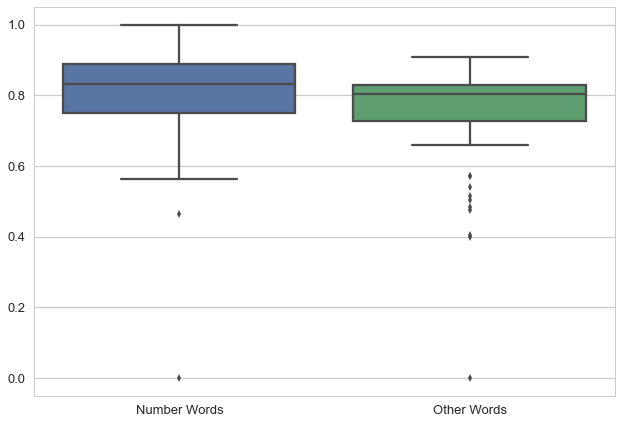

In [18]:
seaborn.boxplot(['Number Words', 'Other Words'], [df['number_words'].dropna(), df['other_words'].dropna()], orient='v')
plt.show()

Line plot: Edit distances by language for number words and other words.

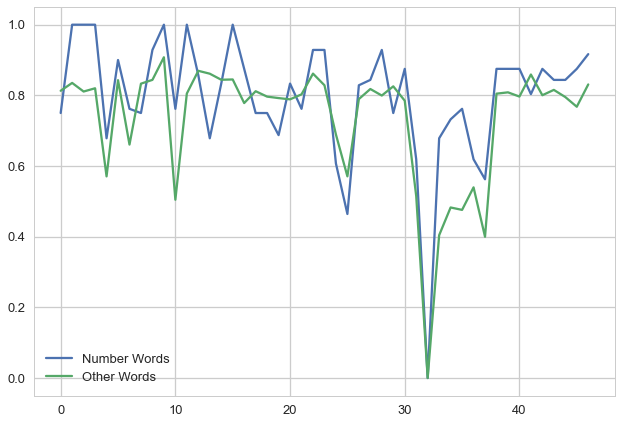

In [19]:
x = range(len(all_langs))
plt.plot(x, df['number_words'], label="Number Words")
plt.plot(x, df['other_words'], label="Other Words")
plt.legend(loc="best")
plt.show()

#### Statistical Analysis
We can do a t-test on the mean edit distances of the number words and the other words to see if they are statistically significantly different.<br>
**Null Hypothesis**: The means of 'number' words = the mean of 'other' words 

In [20]:
p_value = sp.stats.ttest_ind(df.values[-1], df.values[-2], nan_policy='omit')[1]

if p_value < 0.05:
    print('The p-value is %4.4f. This allows us to reject the null hypothesis.' % p_value)
else:
    print('The p-value is %4.4f. This does not allow us to reject the null hypothesis.' % p_value)

The p-value is 0.1398. This does not allow us to reject the null hypothesis.


### 1.3 METRIC: Normalized Hamming

#### Dataframe based on normalized Hamming:
We can analyze all the results with respect to normalized hamming

In [21]:
#Create an empty dataframe with columns as words and multi index (language, cluster)
df = pd.DataFrame(columns = words, index = index_adv, dtype=float)

for (lang, cluster) in all_langs:
    for word in words:
        try:
            df.loc[(lang, cluster),word] = similarity_metric('norm_hamming', 'ENGLISH', lang, word)
        except:
            pass   #for words not found in a particular language   
                
#Missing Value imputations
#df.fillna(df.median(), inplace=True)
df.groupby(level=['cluster']).mean()

,one,two,I,you,we,person,fish,dog,louse,tree,...,star,water,stone,fire,path,mountain,night,full,new,name
cluster,,,,,,,,,,,,,,,,,,,,,
ancient,0.888889,0.750000,0.909091,0.653846,0.500000,1.000000,NaN,0.833333,1.00,0.888889,...,0.666667,0.422222,0.700,0.65625,0.666667,0.857143,0.875000,0.133333,NaN,1.000000
non_extinct,0.666667,0.500000,0.850000,0.625000,0.666667,0.416667,0.750000,0.666667,0.25,0.629630,...,0.750000,0.300000,0.500,0.50000,0.740741,0.428571,0.416667,0.333333,0.0,0.366667
recently_extinct,0.750000,0.714286,0.888889,0.590909,1.000000,1.000000,0.888889,0.733333,1.00,1.000000,...,1.000000,0.900000,0.625,0.87500,0.888889,0.857143,0.625000,0.875000,0.5,0.424242


In [22]:
number_words = list(df.columns[:2])
other_words = list(df.columns[2:])

df['number_words'] = df[number_words].mean(axis=1)
df['other_words'] = df[other_words].mean(axis=1)

df[['number_words', 'other_words']].groupby(level=['cluster']).mean()

,number_words,other_words
cluster,,
ancient,0.854167,0.710160
non_extinct,0.574074,0.732051
recently_extinct,0.729167,0.825735


### Visualizations
Box and whisker plot: colored box is the middle 50th percentile, whiskers are the 25th to 75th percentile, any outliers are represented by dots.

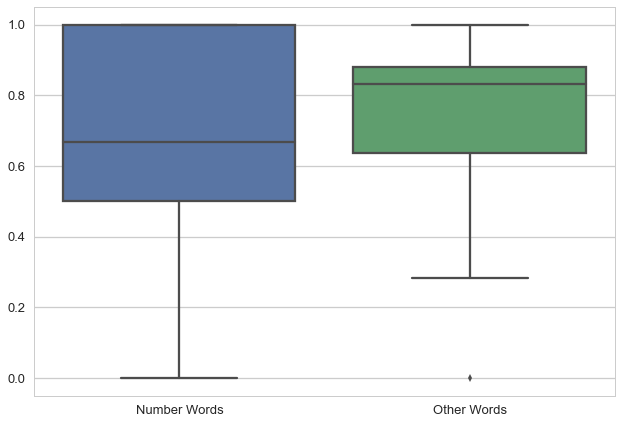

In [23]:
seaborn.boxplot(['Number Words', 'Other Words'], [df['number_words'].dropna(), df['other_words'].dropna()], orient='v')
plt.show()

Line plot: Edit distances by language for number words and other words.

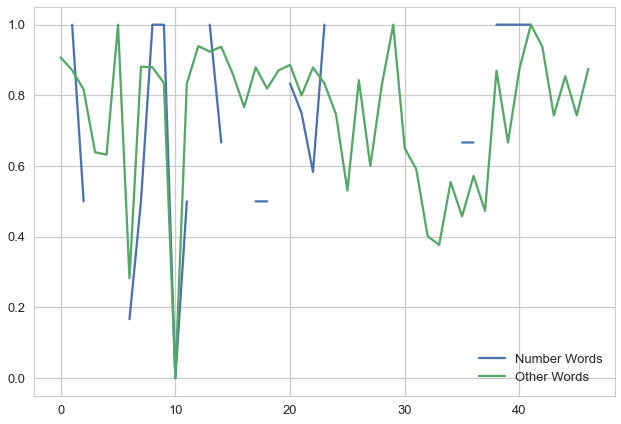

In [24]:
x = range(len(all_langs))
plt.plot(x, df['number_words'], label="Number Words")
plt.plot(x, df['other_words'], label="Other Words")
plt.legend(loc="best")
plt.show()

#### Statistical Analysis
We can do a t-test on the mean edit distances of the number words and the other words to see if they are statistically significantly different.<br>
**Null Hypothesis**: The means of 'number' words = the mean of 'other' words 

In [25]:
p_value = sp.stats.ttest_ind(df.values[-1], df.values[-2], nan_policy='omit')[1]

if p_value < 0.05:
    print('The p-value is %4.4f. This allows us to reject the null hypothesis.' % p_value)
else:
    print('The p-value is %4.4f. This does not allow us to reject the null hypothesis.' % p_value)

The p-value is 0.2133. This does not allow us to reject the null hypothesis.


### 1.4 METRIC : Jaccard

#### Dataframe based on Jaccard


In [26]:
#Create an empty dataframe with columns as words and multi index (language, cluster)
df = pd.DataFrame(columns = words, index = index_adv, dtype=float)

for (lang, cluster) in all_langs:
    for word in words:
        try:
            df.loc[(lang, cluster),word] = similarity_metric('jaccard', 'ENGLISH', lang, word)
        except:
            pass   #for words not found in a particular language    
                 
#Missing Value imputations
#df.fillna(df.median(), inplace=True)
df.groupby(level=['cluster']).mean()

,one,two,I,you,we,person,fish,dog,louse,tree,...,star,water,stone,fire,path,mountain,night,full,new,name
cluster,,,,,,,,,,,,,,,,,,,,,
ancient,0.877315,0.853571,0.843137,0.785185,0.779412,0.887317,0.804692,0.872487,0.569792,0.833563,...,0.416667,0.656047,0.750689,0.700265,0.874868,0.902260,0.717732,0.585582,0.700833,0.595113
non_extinct,0.852564,0.705128,0.861111,0.694444,0.826923,0.754286,0.852778,0.856410,0.536111,0.725641,...,0.562951,0.815476,0.771726,0.783150,0.825694,0.755952,0.700641,0.690476,0.669444,0.567308
recently_extinct,0.798718,0.824359,0.916667,0.683333,0.839744,0.858168,0.876389,0.914652,0.861111,0.864927,...,0.659921,0.711355,0.868750,0.818590,0.950000,0.647751,0.785913,0.829762,0.652564,0.557692


In [27]:
number_words = list(df.columns[:2])
other_words = list(df.columns[2:])

df['number_words'] = df[number_words].mean(axis=1)
df['other_words'] = df[other_words].mean(axis=1)


### Visualizations
Box and whisker plot: colored box is the middle 50th percentile, whiskers are the 25th to 75th percentile, any outliers are represented by dots.

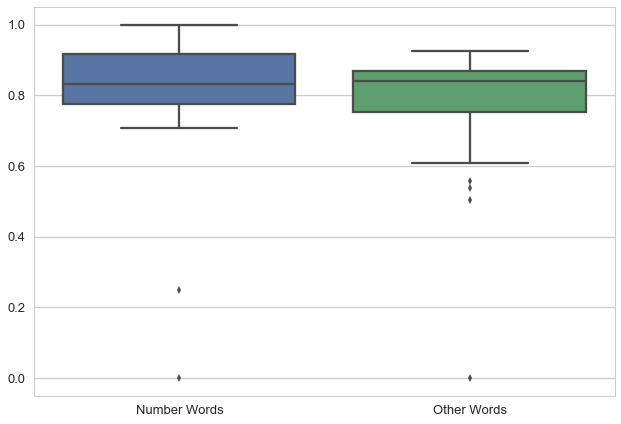

In [28]:
seaborn.boxplot(['Number Words', 'Other Words'], [df['number_words'].dropna(), df['other_words'].dropna()], orient='v')
plt.show()

Line plot: Edit distances by language for number words and other words.

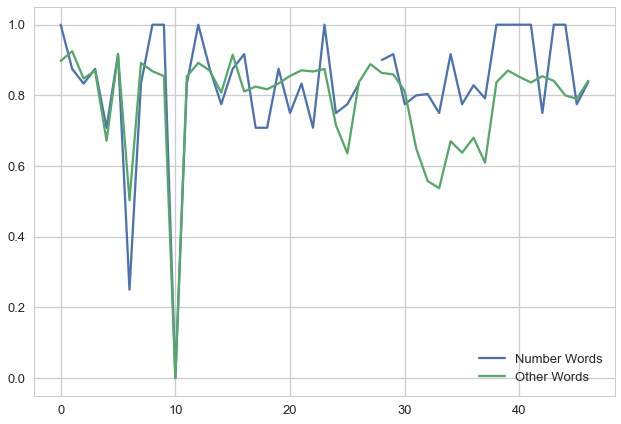

In [29]:
x = range(len(all_langs))
plt.plot(x, df['number_words'], label="Number Words")
plt.plot(x, df['other_words'], label="Other Words")
plt.legend(loc="best")
plt.show()

#### Statistical Analysis
We can do a t-test on the mean edit distances of the number words and the other words to see if they are statistically significantly different.<br>
**Null Hypothesis**: The means of 'number' words = the mean of 'other' words 

In [30]:
p_value = sp.stats.ttest_ind(df.values[-1], df.values[-2], nan_policy='omit')[1]

if p_value < 0.05:
    print('The p-value is %4.4f. This allows us to reject the null hypothesis.' % p_value)
else:
    print('The p-value is %4.4f. This does not allow us to reject the null hypothesis.' % p_value)

The p-value is 0.1590. This does not allow us to reject the null hypothesis.


## Section 2. Afro-Asiatic Languages

Now we apply the same approach to a different classification of languages.
Let's see what conclusions we come to in this case

In [31]:
#Store the names of languages in a list 
ancient_l = ancient_langs(afro_asia)
rec_ext_l = recently_extinct(afro_asia)
new_lang_l = new_languages(afro_asia)


all_langs = new_lang_l + rec_ext_l + ancient_l

#Multi index for pandas dataframe
index_adv = pd.MultiIndex.from_tuples(all_langs, names=['language', 'cluster'])

18 ancient languages stored
['LATE_EGYPTIAN', 'MIDDLE_EGYPTIAN', 'AKKADIAN', 'AKKADIAN_2', 'ARABIC_QURANIC', 'CLASSICAL_ARABIC', 'STANDARD_ARABIC', 'UGARITIC', 'ARAMAIC_ANCIENT', 'ACHAEMENID_ARAMAIC', 'CLASSICAL_MANDAIC', 'BIBLICAL_HEBREW', 'PHOENICIAN', 'SABEAN', 'ETHIOPIC', 'GEEZ', 'GEEZ_2', 'GEEZ_3']


12 recently extinct languages stored
['FOQAHA', 'HOLMA', 'TESHENAWA', 'KWADZA', 'COPTIC', 'CLASSICAL_SYRIAC', 'SYRIAC', 'SYRIAC_2', 'MLAHSO', 'GAFAT', 'MESMES', 'MESMES_2']


13 new languages stored
['BAZZA', 'MWAGHAVUL', 'FALI_GILI', 'BUDUMA', 'TSAMAI', 'BILIN_2', 'BURUNGE', 'SOMRAI', 'DAHALO_2', 'GHYE', 'SHA', 'CUVOK', 'KULERE']




### 2.1 Metric: EDIT DISTANCE
#### Dataframe to compare EDIT DISTANCES between phonemes of words in different languages

In [32]:
#Create an empty dataframe with columns as words and multi index (language, cluster)
df = pd.DataFrame(columns = words, index = index_adv, dtype=float)

#Evaluate metrics for each pair of language
for (lang, cluster) in all_langs:
    for word in words:
        try:
            df.loc[(lang, cluster),word] = similarity_metric('edit_d', 'CLASSICAL_ARABIC', lang, word)
        except:
            pass   #for words not found in a particular language     

#Missing Value imputations by Median
#df.fillna(df.median(), inplace=True)

#Mean Grouping by clsuters
df.groupby(level=['cluster']).mean()

,one,two,I,you,we,person,fish,dog,louse,tree,...,star,water,stone,fire,path,mountain,night,full,new,name
cluster,,,,,,,,,,,,,,,,,,,,,
ancient,2.777778,4.411765,2.062500,2.687500,2.357143,5.352941,3.666667,1.466667,4.500000,5.642857,...,4.200000,1.611111,5.666667,2.333333,5.722222,3.647059,4.055556,3.272727,2.928571,1.941176
non_extinct,4.750000,5.333333,3.250000,3.750000,5.125000,6.000000,4.769231,4.166667,6.090909,6.166667,...,6.846154,3.076923,6.000000,3.250000,5.916667,4.666667,5.307692,5.750000,4.555556,3.538462
recently_extinct,3.916667,5.090909,2.888889,3.333333,3.750000,5.363636,4.428571,2.833333,5.375000,6.363636,...,5.600000,2.636364,6.583333,3.272727,5.800000,5.000000,5.333333,4.250000,4.666667,3.200000


In [33]:
number_words = list(df.columns[:2])
other_words = list(df.columns[2:])

df['number_words'] = df[number_words].mean(axis=1)
df['other_words'] = df[other_words].mean(axis=1)

df[['number_words', 'other_words']].groupby(level=['cluster']).mean()

,number_words,other_words
cluster,,
ancient,3.583333,3.190399
non_extinct,5.038462,4.728155
recently_extinct,4.458333,4.429875


### Visualizations
Box and whisker plot: colored box is the middle 50th percentile, whiskers are the 25th to 75th percentile, any outliers are represented by dots.

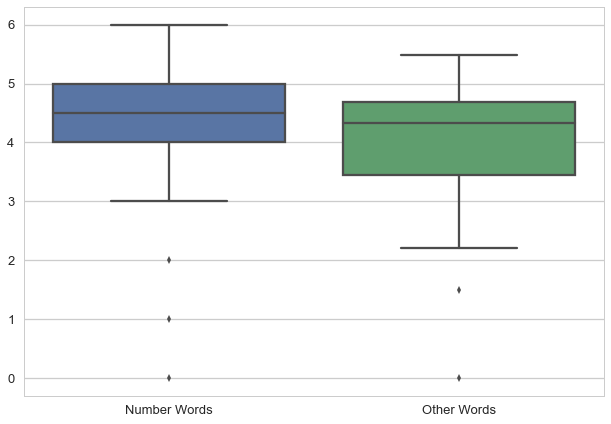

In [34]:
seaborn.boxplot(['Number Words', 'Other Words'], [df['number_words'].dropna(), df['other_words'].dropna()], orient='v')
plt.show()

Line plot: Edit distances by language for number words and other words.

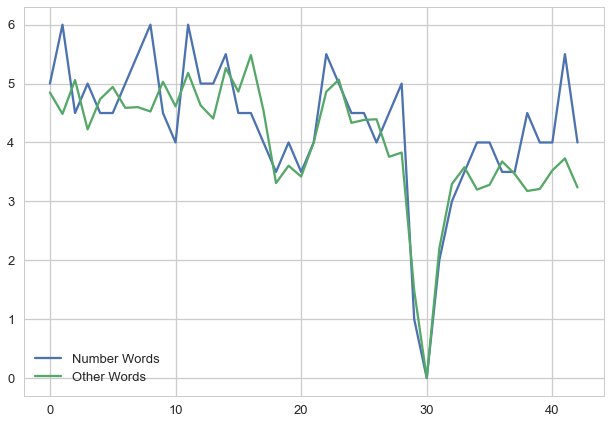

In [35]:
x = range(len(all_langs))
plt.plot(x, df['number_words'], label="Number Words")
plt.plot(x, df['other_words'], label="Other Words")
plt.legend(loc="best")
plt.show()

#### Statistical Analysis
We can do a t-test on the mean edit distances of the number words and the other words to see if they are statistically significantly different.<br>
**Null Hypothesis**: The means of 'number' words = the mean of 'other' words 

In [36]:
p_value = sp.stats.ttest_ind(df.values[-1], df.values[-2], nan_policy='omit')[1]

if p_value < 0.05:
    print('The p-value is %4.4f. This allows us to reject the null hypothesis.' % p_value)
else:
    print('The p-value is %4.4f. This does not allow us to reject the null hypothesis.' % p_value)

The p-value is 0.2057. This does not allow us to reject the null hypothesis.


### 2.2 METRIC: Normalized Edit DISTANCE

#### Dataframe based on normalized Edit Distance:

In [37]:
#Create an empty dataframe with columns as words and multi index (language, cluster)
df = pd.DataFrame(columns = words, index = index_adv, dtype=float)

for (lang, cluster) in all_langs:
    for word in words:
        try:
            df.loc[(lang, cluster),word] = similarity_metric('norm_hamming', 'CLASSICAL_ARABIC', lang, word)
        except:
            pass   #for words not found in a particular language   
            
            
df.groupby(level=['cluster']).mean()

,one,two,I,you,we,person,fish,dog,louse,tree,...,star,water,stone,fire,path,mountain,night,full,new,name
cluster,,,,,,,,,,,,,,,,,,,,,
ancient,0.714286,0.291667,0.0000,0.5,0.2,0.500000,0.2,0.125,0.500000,0.0,...,0.8,0.366667,0.000000,0.333333,0.000000,0.542857,0.083333,0.0,0.314286,0.545455
non_extinct,0.800000,1.000000,NaN,1.0,1.0,1.000000,1.0,0.750,NaN,NaN,...,NaN,0.666667,NaN,1.000000,NaN,0.800000,0.888889,NaN,0.666667,0.916667
recently_extinct,NaN,0.888889,0.9375,NaN,0.9,0.833333,0.8,0.800,0.888889,NaN,...,1.0,0.800000,0.928571,0.333333,0.571429,0.933333,0.833333,NaN,0.866667,0.857143


In [38]:
number_words = list(df.columns[:2])
other_words = list(df.columns[2:])

df['number_words'] = df[number_words].mean(axis=1)
df['other_words'] = df[other_words].mean(axis=1)

df[['number_words', 'other_words']].groupby(level=['cluster']).mean()

,number_words,other_words
cluster,,
ancient,0.697917,0.556911
non_extinct,0.850000,0.868037
recently_extinct,0.888889,0.855620


### Visualizations
Box and whisker plot: colored box is the middle 50th percentile, whiskers are the 25th to 75th percentile, any outliers are represented by dots.

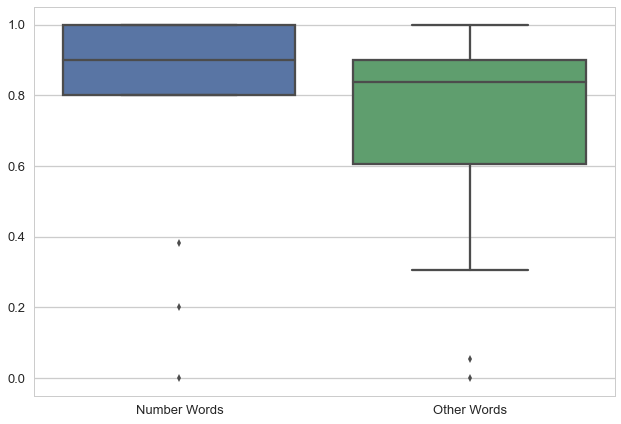

In [39]:
seaborn.boxplot(['Number Words', 'Other Words'], [df['number_words'].dropna(), df['other_words'].dropna()], orient='v')
plt.show()

Line plot: Edit distances by language for number words and other words.

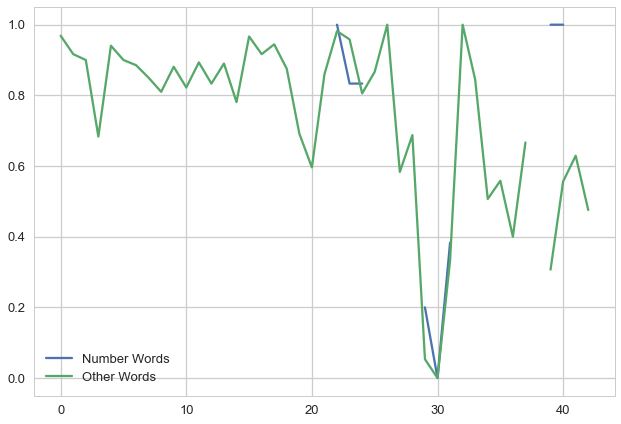

In [40]:
x = range(len(all_langs))
plt.plot(x, df['number_words'], label="Number Words")
plt.plot(x, df['other_words'], label="Other Words")
plt.legend(loc="best")
plt.show()

#### Statistical Analysis
We can do a t-test on the mean edit distances of the number words and the other words to see if they are statistically significantly different.<br>
**Null Hypothesis**: The means of 'number' words = the mean of 'other' words 

In [41]:
p_value = sp.stats.ttest_ind(df.values[-1], df.values[-2], nan_policy='omit')[1]

if p_value < 0.05:
    print('The p-value is %4.4f. This allows us to reject the null hypothesis.' % p_value)
else:
    print('The p-value is %4.4f. This does not allow us to reject the null hypothesis.' % p_value)

The p-value is 0.4056. This does not allow us to reject the null hypothesis.


### 2.3 METRIC: Normalized Hamming

#### Dataframe based on normalized Hamming:

In [42]:
#Create an empty dataframe with columns as words and multi index (language, cluster)
df = pd.DataFrame(columns = words, index = index_adv, dtype=float)

for (lang, cluster) in all_langs:
    for word in words:
        try:
            df.loc[(lang, cluster),word] = similarity_metric('norm_hamming', 'CLASSICAL_ARABIC', lang, word)
        except:
            pass   #for words not found in a particular language   
            
            
    
#Missing Value imputations
df.groupby(level=['cluster']).mean()

,one,two,I,you,we,person,fish,dog,louse,tree,...,star,water,stone,fire,path,mountain,night,full,new,name
cluster,,,,,,,,,,,,,,,,,,,,,
ancient,0.714286,0.291667,0.0000,0.5,0.2,0.500000,0.2,0.125,0.500000,0.0,...,0.8,0.366667,0.000000,0.333333,0.000000,0.542857,0.083333,0.0,0.314286,0.545455
non_extinct,0.800000,1.000000,NaN,1.0,1.0,1.000000,1.0,0.750,NaN,NaN,...,NaN,0.666667,NaN,1.000000,NaN,0.800000,0.888889,NaN,0.666667,0.916667
recently_extinct,NaN,0.888889,0.9375,NaN,0.9,0.833333,0.8,0.800,0.888889,NaN,...,1.0,0.800000,0.928571,0.333333,0.571429,0.933333,0.833333,NaN,0.866667,0.857143


In [43]:
number_words = list(df.columns[:2])
other_words = list(df.columns[2:])

df['number_words'] = df[number_words].mean(axis=1)
df['other_words'] = df[other_words].mean(axis=1)

df[['number_words', 'other_words']].groupby(level=['cluster']).mean()

,number_words,other_words
cluster,,
ancient,0.697917,0.556911
non_extinct,0.850000,0.868037
recently_extinct,0.888889,0.855620


### Visualizations
Box and whisker plot: colored box is the middle 50th percentile, whiskers are the 25th to 75th percentile, any outliers are represented by dots.

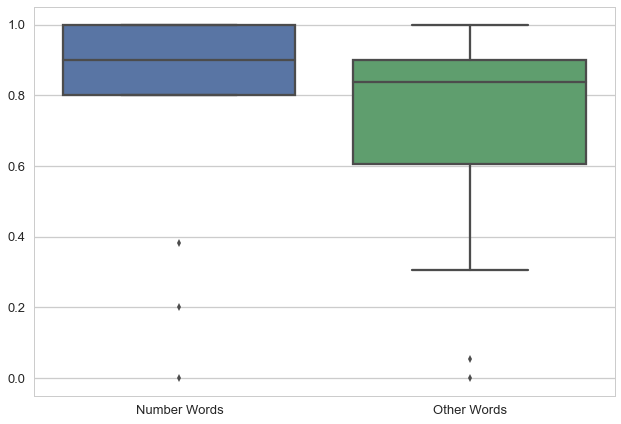

In [44]:
seaborn.boxplot(['Number Words', 'Other Words'], [df['number_words'].dropna(), df['other_words'].dropna()], orient='v')
plt.show()

Line plot: Edit distances by language for number words and other words.

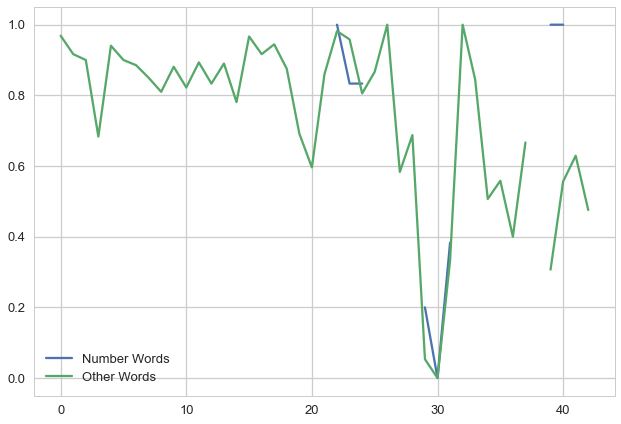

In [45]:
x = range(len(all_langs))
plt.plot(x, df['number_words'], label="Number Words")
plt.plot(x, df['other_words'], label="Other Words")
plt.legend(loc="best")
plt.show()

#### Statistical Analysis
We can do a t-test on the mean edit distances of the number words and the other words to see if they are statistically significantly different.<br>
**Null Hypothesis**: The means of 'number' words = the mean of 'other' words 

In [46]:
p_value = sp.stats.ttest_ind(df.values[-1], df.values[-2], nan_policy='omit')[1]

if p_value < 0.05:
    print('The p-value is %4.4f. This allows us to reject the null hypothesis.' % p_value)
else:
    print('The p-value is %4.4f. This does not allow us to reject the null hypothesis.' % p_value)

The p-value is 0.4056. This does not allow us to reject the null hypothesis.


### 2.4 METRIC : Jaccard

#### Dataframe based on Jaccard


In [47]:
#Create an empty dataframe with columns as words and multi index (language, cluster)
df = pd.DataFrame(columns = words, index = index_adv, dtype=float)

for (lang, cluster) in all_langs:
    for word in words:
        try:
            df.loc[(lang, cluster),word] = similarity_metric('jaccard', 'CLASSICAL_ARABIC', lang, word)
        except:
            pass   #for words not found in a particular language    
                 
#Missing Value imputations

df.groupby(level=['cluster']).mean()


,one,two,I,you,we,person,fish,dog,louse,tree,...,star,water,stone,fire,path,mountain,night,full,new,name
cluster,,,,,,,,,,,,,,,,,,,,,
ancient,0.542460,0.677731,0.505208,0.503571,0.464286,0.717087,0.764444,0.296667,0.614881,0.818878,...,0.817143,0.582804,0.822024,0.642063,0.756538,0.771639,0.743651,0.515152,0.630272,0.591176
non_extinct,0.894114,0.864153,0.758333,0.702827,0.821429,0.901407,0.782112,0.868915,0.903388,0.918089,...,0.879720,0.552473,0.884488,0.859722,0.840963,0.918816,0.871215,0.889286,0.766667,0.767216
recently_extinct,0.719048,0.825577,0.690741,0.613889,0.594494,0.793218,0.849830,0.621825,0.747966,0.936869,...,0.932143,0.686364,0.932008,0.720346,0.789318,0.938167,0.736574,0.738095,0.816138,0.808889


In [48]:
number_words = list(df.columns[:2])
other_words = list(df.columns[2:])

df['number_words'] = df[number_words].mean(axis=1)
df['other_words'] = df[other_words].mean(axis=1)

df[['number_words', 'other_words']].groupby(level=['cluster']).mean()

,number_words,other_words
cluster,,
ancient,0.613492,0.607776
non_extinct,0.882021,0.841455
recently_extinct,0.771247,0.774154


### Visualizations
Box and whisker plot: colored box is the middle 50th percentile, whiskers are the 25th to 75th percentile, any outliers are represented by dots.

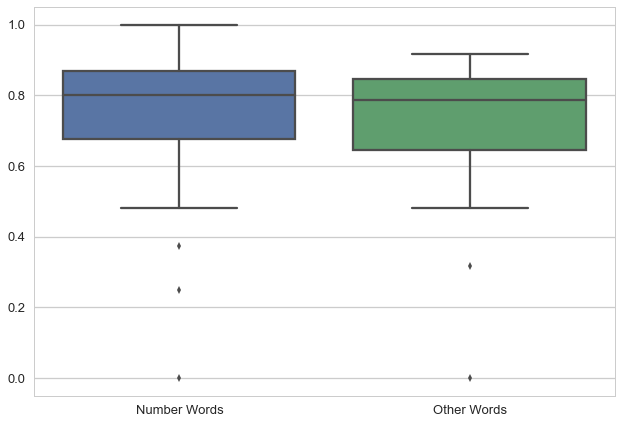

In [49]:
seaborn.boxplot(['Number Words', 'Other Words'], [df['number_words'].dropna(), df['other_words'].dropna()], orient='v')
plt.show()

Line plot: Edit distances by language for number words and other words.

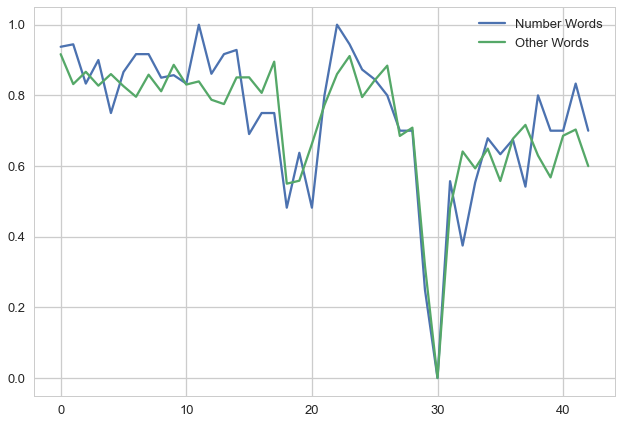

In [50]:
x = range(len(all_langs))
plt.plot(x, df['number_words'], label="Number Words")
plt.plot(x, df['other_words'], label="Other Words")
plt.legend(loc="best")
plt.show()

#### Statistical Analysis
We can do a t-test on the mean edit distances of the number words and the other words to see if they are statistically significantly different.<br>
**Null Hypothesis**: The means of 'number' words = the mean of 'other' words 

In [51]:
p_value = sp.stats.ttest_ind(df.values[-1], df.values[-2], nan_policy='omit')[1]
if p_value < 0.05:
    print('The p-value is %4.4f. This allows us to reject the null hypothesis.' % p_value)
else:
    print('The p-value is %4.4f. This does not allow us to reject the null hypothesis.' % p_value)

The p-value is 0.0416. This allows us to reject the null hypothesis.
